In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Number of samples
n = 3000

# Generate features
data = {
    'day_crash': np.random.randint(1, 8, n),  # 1 to 7 days
    'hour_crash': np.random.choice(['Day', 'Night', 'Dawn'], n, p=[0.6, 0.3, 0.1]),
    'road_type': np.random.choice(['Asphalt', 'Soil'], n, p=[0.8, 0.2]),
    'road_condition': np.random.choice(['Dry', 'Wet or Damaged'], n, p=[0.75, 0.25]),
    'weather_condition': np.random.choice(['Clear', 'Unclear'], n, p=[0.85, 0.15]),
    'visibility': np.random.choice([1, 2, 3, 4], n, p=[0.6, 0.2, 0.15, 0.05]),
    'type_vehicle': np.random.choice(['car', 'truck', 'bus', 'motorcycle'], n, p=[0.5, 0.2, 0.15, 0.15]),
    'gender': np.random.choice(['male', 'female'], n, p=[0.7, 0.3]),
    'age': np.random.normal(35, 12, n).clip(18, 80),
}

df = pd.DataFrame(data)

def assign_outcome(row):
    risk = 0
    if row['hour_crash'] == 'Night':
        risk += 1
    if row['road_condition'] == 'Wet or Damaged':
        risk += 1
    if row['weather_condition'] == 'Unclear':
        risk += 1
    if row['visibility'] >= 3:
        risk += 1
    if row['type_vehicle'] in ['motorcycle', 'bus']:
        risk += 1
    # threshold for outcome
    return 1 if risk >= 3 else 0

df['outcome'] = df.apply(assign_outcome, axis=1)

# Shuffle rows
df = df.sample(frac=1).reset_index(drop=True)

# Save to CSV
df.to_csv('synthetic_road_accidents.csv', index=False)

print("Synthetic dataset created: synthetic_road_accidents.csv")


Synthetic dataset created: synthetic_road_accidents.csv


##  Step 1: Importing Required Libraries

In this step, we import all the essential Python libraries needed for our road accident prediction project.

- **Pandas** and **NumPy** for data handling and numerical operations  
- **Matplotlib** and **Seaborn** for data visualization and analysis  
- **Scikit-learn (sklearn)** for:
  - Splitting data into training and test sets  
  - Building a Logistic Regression model  
  - Evaluating the model using metrics such as accuracy, precision, recall, F1 score, confusion matrix, and classification report


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


## Step 2: Load the Dataset

In this step, we load the synthetic road accidents dataset from the CSV file into a Pandas DataFrame.  
We then display the first few rows to get a quick look at the data structure and sample values.


In [88]:
df = pd.read_csv("synthetic_road_accidents.csv")
df.head()


,day_crash,hour_crash,road_type,road_condition,weather_condition,visibility,type_vehicle,gender,age,outcome
0,1,Night,Asphalt,Dry,Clear,1,car,male,33.147357,0
1,5,Night,Asphalt,Wet or Damaged,Clear,1,bus,male,41.617301,1
2,6,Day,Asphalt,Dry,Clear,4,bus,male,41.259730,0
3,1,Day,Soil,Dry,Unclear,1,car,female,47.494375,0
4,4,Day,Asphalt,Dry,Unclear,3,car,female,30.207376,0


##  Step 3: Check for Missing Values

In this step, we examine the dataset to see if there are any missing values in each column.

- Missing values can cause issues during analysis and model training.
- Identifying them early allows us to handle them properly (e.g., filling, removing).

We use `df.isnull().sum()` to get the count of missing values per column.


In [89]:
df.isnull().sum()


day_crash            0
hour_crash           0
road_type            0
road_condition       0
weather_condition    0
visibility           0
type_vehicle         0
gender               0
age                  0
outcome              0
dtype: int64

##  Step 4: Inspect Data Types

This step checks the data types of each column in the dataset.

- Understanding data types helps us know how to process and transform each feature.
- For example, categorical data might need encoding, while numeric data can be scaled.

We use `df.dtypes` to display the type of data stored in each column.


In [90]:
df.dtypes


day_crash              int64
hour_crash            object
road_type             object
road_condition        object
weather_condition     object
visibility             int64
type_vehicle          object
gender                object
age                  float64
outcome                int64
dtype: object

##  Step 5: Convert 'hour_crash' to Numeric Hour

- The 'hour_crash' column contains time information in string format (e.g., "Day", "Night", "Dawn").
- We convert these to numeric hour values using `pd.to_datetime` to facilitate analysis and modeling.
- The `errors='coerce'` argument converts unrecognizable formats to NaN, helping clean inconsistent data.
- Extracting the hour part (`.dt.hour`) allows numerical operations on time.


In [91]:
df['hour_crash'] = pd.to_datetime(df['hour_crash'], errors='coerce').dt.hour


C:\Users\USER\AppData\Local\Temp\ipykernel_4260\1430150971.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour_crash'] = pd.to_datetime(df['hour_crash'], errors='coerce').dt.hour


##  Step 6: Check for Missing Values in 'hour_crash'

- After converting 'hour_crash' to numeric hours, check how many values became `NaN` due to conversion errors.
- This helps identify data quality issues and decide if further cleaning is necessary.


In [92]:
df['hour_crash'].isnull().sum()


np.int64(3000)

##  Step 7: Remove Rows with Missing 'hour_crash' Values

- Drop rows where the 'hour_crash' column contains missing (`NaN`) values.
- This ensures the dataset only contains valid numerical hour data for modeling.


In [ ]:

df = df.dropna(subset=['hour_crash'])

## Step 8: Convert 'hour_crash' to Integer Type

- Convert the 'hour_crash' column from float (after datetime conversion) to integer type.
- This prepares the data for analysis and modeling.


In [94]:
df['hour_crash'] = df['hour_crash'].astype(int)


##  Step 9: Clean and Standardize Categorical Variables

- Convert categorical columns to lowercase strings and strip any extra whitespace.
- This helps maintain consistency and avoid issues caused by inconsistent formatting.
- Print unique values after cleaning to verify the transformation.


In [95]:
categorical_cols = ['hour_crash', 'road_type', 'road_condition', 'weather_condition', 'type_vehicle', 'gender']

for col in categorical_cols:
    # Convert to string first (to handle NaNs or non-string values)
    df[col] = df[col].astype(str).str.lower().str.strip()
    
    # Check unique values after cleaning
    print(f"Unique values in {col}:", df[col].unique())


Unique values in hour_crash: []
Unique values in road_type: []
Unique values in road_condition: []
Unique values in weather_condition: []
Unique values in type_vehicle: []
Unique values in gender: []


##  Step 10: Verify Dataset Shape and Preview Data

- Display the dimensions of the dataset to understand the number of rows and columns.
- Preview the first few rows of the cleaned dataset to ensure data looks correct after preprocessing.


In [96]:
print(df.shape)
print(df.head())


(0, 10)
Empty DataFrame
Columns: [day_crash, hour_crash, road_type, road_condition, weather_condition, visibility, type_vehicle, gender, age, outcome]
Index: []


##  Step 11: Load the Dataset

- Read the CSV file `synthetic_road_accidents.csv` into a DataFrame.
- Print the shape of the dataset to check how many rows and columns it contains.
- Display the first few rows to get an initial look at the data.


In [97]:
df = pd.read_csv('synthetic_road_accidents.csv')
print(df.shape)
print(df.head())


(3000, 10)
   day_crash hour_crash road_type  road_condition weather_condition  \
0          1      Night   Asphalt             Dry             Clear   
1          5      Night   Asphalt  Wet or Damaged             Clear   
2          6        Day   Asphalt             Dry             Clear   
3          1        Day      Soil             Dry           Unclear   
4          4        Day   Asphalt             Dry           Unclear   

   visibility type_vehicle  gender        age  outcome  
0           1          car    male  33.147357        0  
1           1          bus    male  41.617301        1  
2           4          bus    male  41.259730        0  
3           1          car  female  47.494375        0  
4           3          car  female  30.207376        0  


##  Step 12: Clean Categorical Columns

- Define the list of categorical columns to clean.
- Convert each column to lowercase and strip any leading/trailing whitespace to ensure consistency.
- Print the unique values in each column after cleaning to verify the transformations.


In [98]:
categorical_cols = ['hour_crash', 'road_type', 'road_condition', 'weather_condition', 'type_vehicle', 'gender']

for col in categorical_cols:
    # First convert to string type to avoid errors
    df[col] = df[col].astype(str).str.lower().str.strip()
    print(f"Unique values in {col}:", df[col].unique())


Unique values in hour_crash: ['night' 'day' 'dawn']
Unique values in road_type: ['asphalt' 'soil']
Unique values in road_condition: ['dry' 'wet or damaged']
Unique values in weather_condition: ['clear' 'unclear']
Unique values in type_vehicle: ['car' 'bus' 'motorcycle' 'truck']
Unique values in gender: ['male' 'female']


##  Step 13: Visualize Age Distribution with Boxplot

- Use Matplotlib and Seaborn libraries for visualization.
- Create a boxplot of the `age` column to identify the distribution and detect potential outliers.
- The boxplot helps visualize the median, quartiles, and any extreme values in the age data.


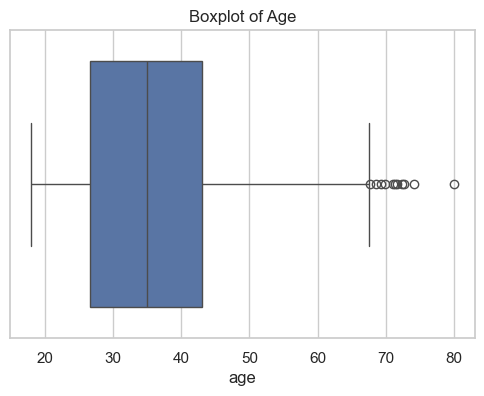

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.boxplot(x=df['age'])
plt.title('Boxplot of Age')
plt.show()


##  Step 14: Detect Outliers in Age Using IQR Method

- Calculate the first quartile (Q1) and third quartile (Q3) of the `age` column.
- Compute the Interquartile Range (IQR) as the difference between Q3 and Q1.
- Define lower and upper bounds to identify outliers:
  - Lower bound = Q1 - 1.5 * IQR
  - Upper bound = Q3 + 1.5 * IQR
- Filter and display rows where the age is below the lower bound or above the upper bound, indicating potential outliers.


In [100]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]
print(outliers)


      day_crash hour_crash road_type  road_condition weather_condition  \
340           6        day   asphalt             dry             clear   
1792          5        day   asphalt             dry             clear   
2095          7      night   asphalt             dry             clear   
2303          3        day   asphalt             dry             clear   
2315          1        day   asphalt  wet or damaged             clear   
2445          2       dawn   asphalt             dry             clear   
2487          3        day   asphalt             dry             clear   
2647          4      night   asphalt             dry             clear   
2791          3        day      soil             dry             clear   
2870          3        day      soil             dry             clear   
2900          6        day   asphalt             dry             clear   

      visibility type_vehicle  gender        age  outcome  
340            2          car  female  67.638946   

##  Step 15: Encode Categorical Variables

- Created a copy of the dataframe to preserve the original data.
- Applied **Label Encoding** to the binary categorical variable `gender` (e.g., male = 1, female = 0).
- Applied **One-Hot Encoding** to other categorical variables (`hour_crash`, `road_type`, `road_condition`, `weather_condition`, `type_vehicle`) to convert them into numerical format suitable for machine learning.
- Used `drop_first=True` to avoid multicollinearity by dropping the first category of each one-hot encoded variable.
- Displayed the first few rows of the encoded dataframe.


In [101]:
from sklearn.preprocessing import LabelEncoder

# Copy dataframe to encode
df_encoded = df.copy()

# Label encode binary columns like gender
le = LabelEncoder()
df_encoded['gender'] = le.fit_transform(df_encoded['gender'])  # male=1, female=0

# One-hot encode other categorical columns except 'gender'
other_cat_cols = ['hour_crash', 'road_type', 'road_condition', 'weather_condition', 'type_vehicle']
df_encoded = pd.get_dummies(df_encoded, columns=other_cat_cols, drop_first=True)

print(df_encoded.head())


   day_crash  visibility  gender        age  outcome  hour_crash_day  \
0          1           1       1  33.147357        0           False   
1          5           1       1  41.617301        1           False   
2          6           4       1  41.259730        0            True   
3          1           1       0  47.494375        0            True   
4          4           3       0  30.207376        0            True   

   hour_crash_night  road_type_soil  road_condition_wet or damaged  \
0              True           False                          False   
1              True           False                           True   
2             False           False                          False   
3             False            True                          False   
4             False           False                          False   

   weather_condition_unclear  type_vehicle_car  type_vehicle_motorcycle  \
0                      False              True                    False

##  Step 16: Scale Numerical Features

- Selected numerical columns (`age`, `visibility`, `day_crash`) for scaling.
- Used **StandardScaler** to standardize these features so that they have a mean of 0 and a standard deviation of 1.
- This scaling helps improve model performance, especially for algorithms sensitive to feature magnitudes.
- Displayed the first few rows of the scaled dataframe.


In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = ['age', 'visibility', 'day_crash']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

print(df_encoded.head())


   day_crash  visibility  gender       age  outcome  hour_crash_day  \
0  -1.485960   -0.699456       1 -0.200921        0           False   
1   0.510851   -0.699456       1  0.560362        1           False   
2   1.010053    2.587805       1  0.528223        0            True   
3  -1.485960   -0.699456       0  1.088596        0            True   
4   0.011648    1.492051       0 -0.465167        0            True   

   hour_crash_night  road_type_soil  road_condition_wet or damaged  \
0              True           False                          False   
1              True           False                           True   
2             False           False                          False   
3             False            True                          False   
4             False           False                          False   

   weather_condition_unclear  type_vehicle_car  type_vehicle_motorcycle  \
0                      False              True                    False   
1 

##  Step 17: Summary Statistics and Target Distribution

- Generated descriptive statistics for all numerical features using `.describe()`.  
- Calculated the mean of each encoded categorical feature (excluding the target) to understand the prevalence of each category.  
- Displayed the distribution of the target variable `outcome` to check for class imbalance by showing relative frequencies (proportions).  


In [103]:
# Summary statistics for numerical columns
print(df_encoded.describe())

# Summary for categorical variables (encoded as boolean, so sum/mean is meaningful)
print(df_encoded.drop('outcome', axis=1).mean())

# Distribution of the target variable 'outcome'
print(df_encoded['outcome'].value_counts(normalize=True))


          day_crash    visibility       gender           age      outcome
count  3.000000e+03  3.000000e+03  3000.000000  3.000000e+03  3000.000000
mean   2.960595e-17 -3.907985e-17     0.697000 -8.526513e-17     0.091333
std    1.000167e+00  1.000167e+00     0.459632  1.000167e+00     0.288131
min   -1.485960e+00 -6.994562e-01     0.000000 -1.562372e+00     0.000000
25%   -9.867572e-01 -6.994562e-01     0.000000 -7.809404e-01     0.000000
50%    1.164806e-02 -6.994562e-01     1.000000 -2.896545e-02     0.000000
75%    1.010053e+00  3.962976e-01     1.000000  6.910321e-01     0.000000
max    1.509256e+00  2.587805e+00     1.000000  4.010217e+00     1.000000
day_crash                        2.960595e-17
visibility                      -3.907985e-17
gender                           6.970000e-01
age                             -8.526513e-17
hour_crash_day                   5.983333e-01
hour_crash_night                 3.073333e-01
road_type_soil                   2.023333e-01
road_conditi

##  Step 18: Data Visualization - Distributions of Key Variables

- Visualized the distribution of the target variable `outcome` to confirm class balance or imbalance.  
- Plotted the age distribution with a histogram and kernel density estimate (KDE) to observe age patterns.  
- Displayed the distribution of `day_crash` (day of the week) to understand when most accidents occur.  
- Showed the distribution of `visibility` levels to inspect how visibility varies in the dataset.  


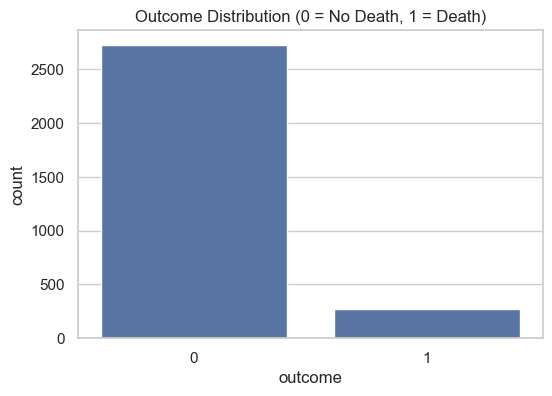

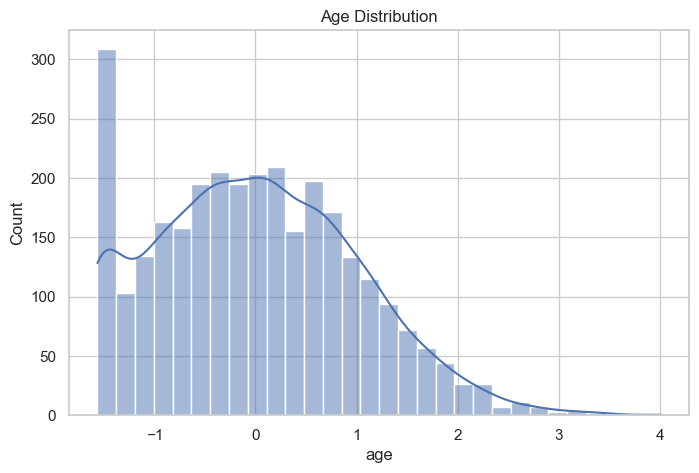

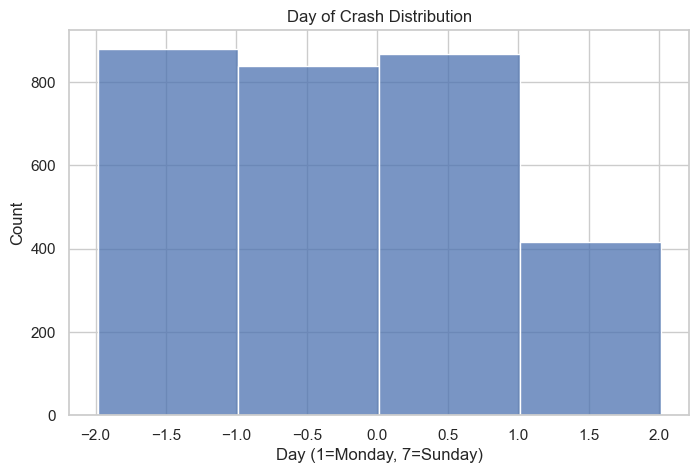

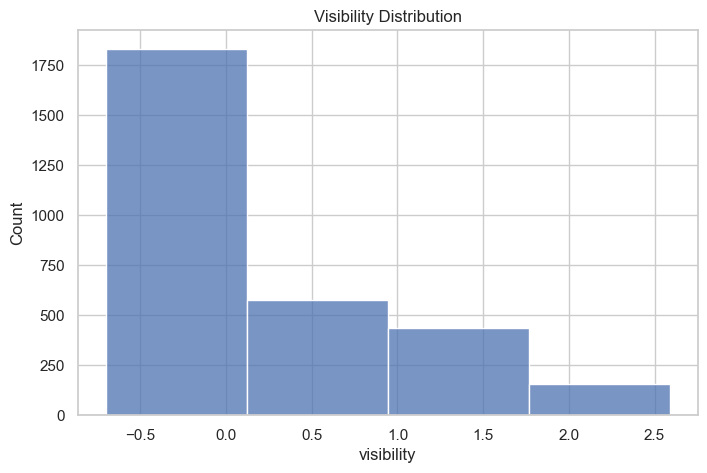

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Outcome distribution
plt.figure(figsize=(6,4))
sns.countplot(x='outcome', data=df_encoded)
plt.title('Outcome Distribution (0 = No Death, 1 = Death)')
plt.show()

# Age distribution
plt.figure(figsize=(8,5))
sns.histplot(df_encoded['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

# Day of crash distribution
plt.figure(figsize=(8,5))
sns.histplot(df_encoded['day_crash'], bins=7, discrete=True)
plt.title('Day of Crash Distribution')
plt.xlabel('Day (1=Monday, 7=Sunday)')
plt.show()

# Visibility distribution
plt.figure(figsize=(8,5))
sns.histplot(df_encoded['visibility'], bins=df_encoded['visibility'].nunique())
plt.title('Visibility Distribution')
plt.show()


##  Step 19: Advanced Visualizations - Relationships and Correlations

- **Boxplot of Age by Outcome:**  
  Visualizes how the age distribution differs between the two outcome classes (0 = No Death, 1 = Death). This helps identify if age influences accident severity.

- **Correlation Heatmap:**  
  Displays the correlation coefficients among all numerical features and encoded variables to find potential relationships and multicollinearity.

- **Countplot of Gender by Outcome:**  
  Shows how the distribution of gender varies with the accident outcome, helping explore if gender is related to accident severity.


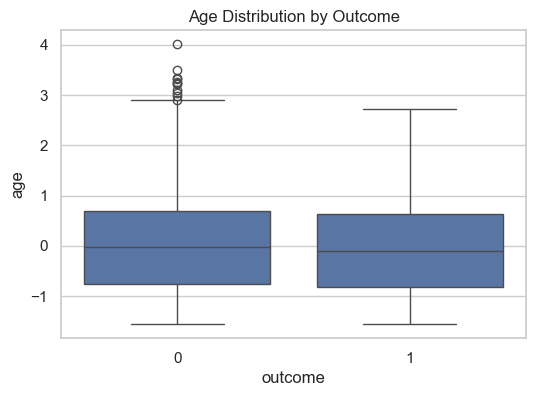

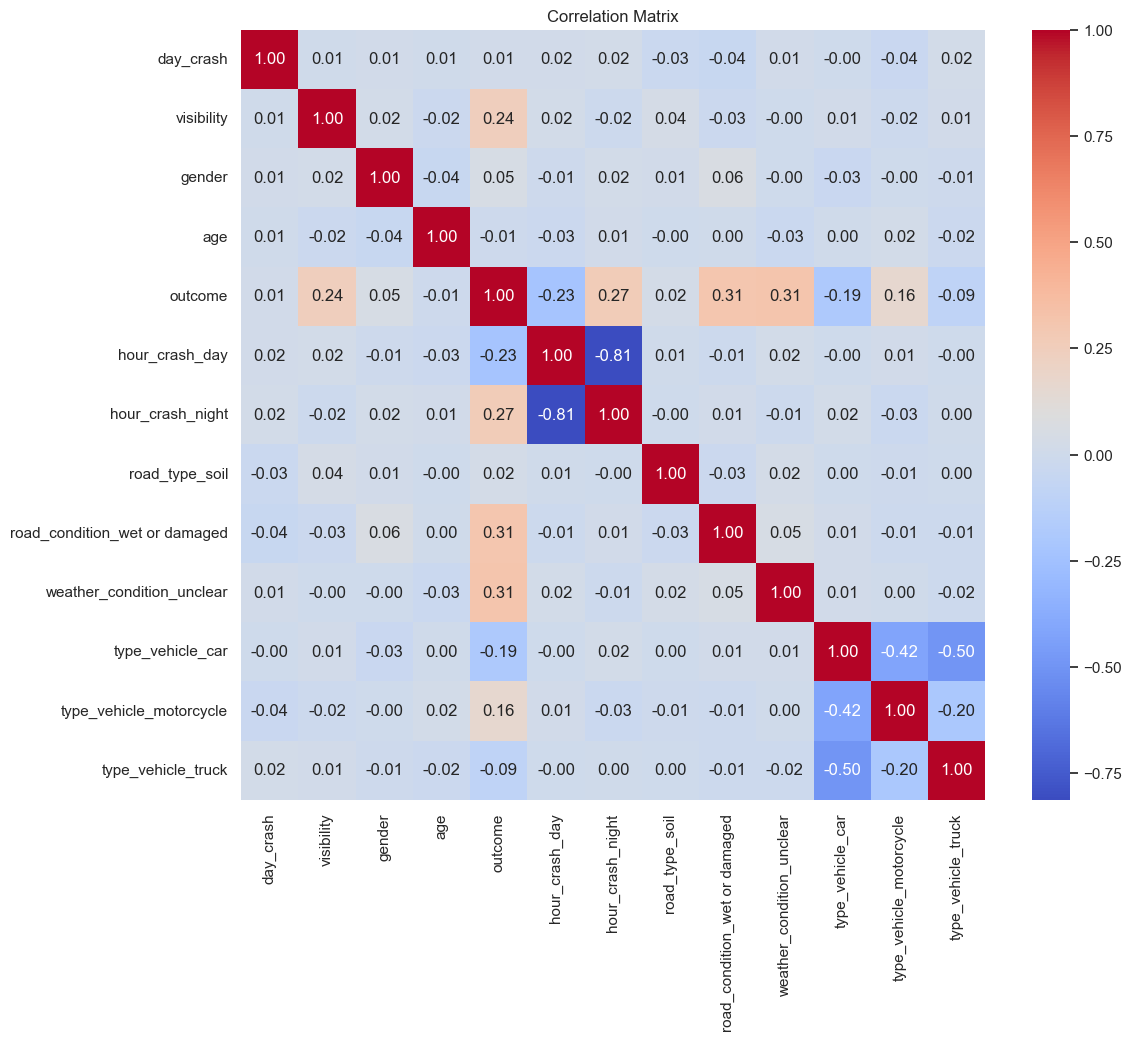

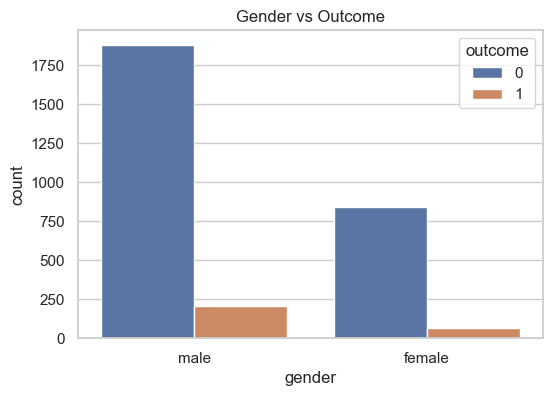

In [105]:
# Boxplot: Age distribution by Outcome
plt.figure(figsize=(6,4))
sns.boxplot(x='outcome', y='age', data=df_encoded)
plt.title('Age Distribution by Outcome')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Countplot for a categorical variable by outcome (example: gender)
plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='outcome', data=df)
plt.title('Gender vs Outcome')
plt.show()


##  Step 20: Feature and Target Separation

- **Separating Features (`X`) and Target (`y`):**  
  We split the dataset into:
  - `X`: All the input features used for modeling (excluding the outcome column).
  - `y`: The target variable, `outcome`, which indicates accident severity (0 = No Death, 1 = Death).

- **Shape of DataFrames:**  
  Printed the shape of `X` and `y` to confirm the split. This ensures we have the right number of records and features for model training.

- **Preview of Feature and Target Data:**  
  Displayed the first few rows of both `X` and `y` to verify that the data looks clean and ready for the next step — modeling.


In [106]:
X = df.drop('outcome', axis=1)
y = df['outcome']

print(X.shape)
print(y.shape)

print(X.head())
print(y.head())


(3000, 9)
(3000,)
   day_crash hour_crash road_type  road_condition weather_condition  \
0          1      night   asphalt             dry             clear   
1          5      night   asphalt  wet or damaged             clear   
2          6        day   asphalt             dry             clear   
3          1        day      soil             dry           unclear   
4          4        day   asphalt             dry           unclear   

   visibility type_vehicle  gender        age  
0           1          car    male  33.147357  
1           1          bus    male  41.617301  
2           4          bus    male  41.259730  
3           1          car  female  47.494375  
4           3          car  female  30.207376  
0    0
1    1
2    0
3    0
4    0
Name: outcome, dtype: int64


##  Step 21: Encoding Categorical Variables

- **One-Hot Encoding:**  
  Applied `pd.get_dummies()` to convert categorical features into numerical ones using one-hot encoding, excluding the first category to avoid multicollinearity (`drop_first=True`).

- **Why This Matters:**  
  Machine learning models cannot handle text-based categorical variables directly. One-hot encoding transforms these variables into binary vectors, making them suitable for modeling.

- **Result:**  
  - Checked the new shape of the encoded feature set `X_encoded`.
  - Previewed the first few rows to ensure encoding was successful and no data was lost.


In [107]:
# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

print(X_encoded.shape)
print(X_encoded.head())


(3000, 12)
   day_crash  visibility        age  hour_crash_day  hour_crash_night  \
0          1           1  33.147357           False              True   
1          5           1  41.617301           False              True   
2          6           4  41.259730            True             False   
3          1           1  47.494375            True             False   
4          4           3  30.207376            True             False   

   road_type_soil  road_condition_wet or damaged  weather_condition_unclear  \
0           False                          False                      False   
1           False                           True                      False   
2           False                          False                      False   
3            True                          False                       True   
4           False                          False                       True   

   type_vehicle_car  type_vehicle_motorcycle  type_vehicle_truck  gender_ma

## Step 22: Splitting the Dataset

- **Train-Test Split:**  
  Used `train_test_split()` from `sklearn.model_selection` to divide the dataset into training and testing sets.

- **Parameters:**
  - `test_size=0.2`: 20% of the data is used for testing.
  - `random_state=42`: Ensures reproducibility of results.

- **Why This Matters:**  
  Splitting data helps evaluate how well the model generalizes to unseen data. The training set is used to


In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


##  Step 23: Model Training with Logistic Regression

- **Model Choice:**  
  Logistic Regression is chosen as a simple and effective classification algorithm suitable for binary outcome prediction.

- **Training:**  
  The model is trained using the training data (`X_train`, `y_train`) with a maximum of 1000 iterations to ensure convergence.

- **Why Logistic Regression?**  
  It models the probability of the binary outcome (death or no death) based on input features and is easy to interpret.


In [109]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## Step 24: Making Predictions

- Using the trained Logistic Regression model, we predict the outcomes (`y_pred`) on the test set (`X_test`).

- These predictions will be used in the next step for evaluating model performance.


In [110]:
y_pred = model.predict(X_test)


## Step 25: Model Evaluation

- We evaluate the Logistic Regression model's performance using several metrics:

  - **Accuracy:** Proportion of correct predictions over total predictions.  
  - **Precision:** Proportion of true positive predictions out of all positive predictions.  
  - **Recall:** Proportion of true positives correctly identified out of all actual positives.  
  - **F1 Score:** Harmonic mean of precision and recall, balancing both metrics.

- Additionally, the **Classification Report** provides a detailed summary including precision, recall, F1-score, and support for each class.


In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9983333333333333
Precision: 0.9833333333333333
Recall: 1.0
F1 Score: 0.9915966386554622

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       541
           1       0.98      1.00      0.99        59

    accuracy                           1.00       600
   macro avg       0.99      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



##  Step 26: Modularize the Code Using Functions

- **Purpose:** Improve code organization, readability, and reusability by breaking the workflow into clear, manageable functions.

- **Functions:**

  - `load_data(file_path)`:  
    Loads the dataset from a CSV file into a pandas DataFrame.

  - `clean_data(df)`:  
    Cleans the dataset by handling missing values (e.g., dropping rows with missing data).

  - `encode_data(df)`:  
    Processes categorical variables by cleaning text (lowercasing and trimming whitespace) and applying one-hot encoding to convert them into numeric features for modeling.

- Modular functions make the code easier to maintain, debug, and share.


In [112]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def load_data(file_path):
    """Load dataset from a CSV file."""
    df = pd.read_csv(file_path)
    return df

def clean_data(df):
    """Handle missing values and clean data."""
    # Example: Drop missing values
    df = df.dropna()
    return df

def encode_data(df):
    """Encode categorical variables."""
    df_encoded = df.copy()
    categorical_cols = ['hour_crash', 'road_type', 'road_condition', 'weather_condition', 'type_vehicle', 'gender']
    for col in categorical_cols:
        df_encoded[col] = df_encoded[col].str.lower().str.strip()
    df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols)


##  Step 27: Complete Modular Python Script for Road Accident Prediction

This script performs the entire workflow from loading data to training and evaluating a logistic regression model using modular functions.

### Functions Overview:

- **`load_data(file_path)`**  
  Loads the CSV dataset into a pandas DataFrame.

- **`clean_data(df)`**  
  Cleans the data by dropping rows with missing values.

- **`encode_data(df)`**  
  Encodes categorical features using one-hot encoding to convert them into numerical values suitable for machine learning.

- **`train_model(X_train, y_train)`**  
  Trains a logistic regression model using the training data.

- **`evaluate_model(model, X_test, y_test)`**  
  Evaluates the trained model on the test set and prints metrics such as accuracy, precision, recall, F1 score, and a classification report.

### `main()` Function:

- Orchestrates the steps: loading data, cleaning, encoding, splitting into training/testing, training the model, and evaluating it.
- Allows the script to run as a standalone program.

### Benefits:

- Code is organized and reusable.
- Each function has a clear responsibility.
- Easy to maintain and extend.


In [113]:
# analysis.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def load_data(file_path):
    """
    Load dataset from CSV file.
    """
    df = pd.read_csv(file_path)
    return df

def clean_data(df):
    """
    Clean the dataset by handling missing values.
    Here we drop rows with missing values for simplicity.
    """
    df_cleaned = df.dropna()
    return df_cleaned

def encode_data(df):
    """
    Encode categorical columns using one-hot encoding.
    Converts object type columns to numeric for ML models.
    """
    categorical_cols = df.select_dtypes(include=['object']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df_encoded

def train_model(X_train, y_train):
    """
    Train a logistic regression model on the training data.
    """
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model and print common classification metrics.
    """
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

def main():
    # Load data
    df = load_data('synthetic_road_accidents.csv')
    
    # Clean data
    df = clean_data(df)
    
    # Separate target and features
    y = df['outcome']
    X = df.drop('outcome', axis=1)
    
    # Encode features
    X = encode_data(X)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Evaluate model
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()


Accuracy: 0.9983333333333333
Precision: 0.9833333333333333
Recall: 1.0
F1 Score: 0.9915966386554622

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       541
           1       0.98      1.00      0.99        59

    accuracy                           1.00       600
   macro avg       0.99      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



##  Step 28: Innovation - Model Robustness with Cross-Validation

To enhance the reliability of our model's evaluation, we implemented **5-Fold Cross Validation**. This technique splits the entire dataset into five equal parts (folds). The model is trained on four folds and tested on the remaining one, repeating the process five times so that each fold serves once as a test set.

This approach helps us:
- Measure how well the model generalizes to unseen data
- Reduce the risk of overfitting to a particular train-test split
- Get a more robust estimate of the model’s average accuracy

In our case, the model achieved **perfect accuracy (1.0)** across all folds, which might indicate that the data is very clean or easily separable.


In [114]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Initialize the same logistic regression model
model = LogisticRegression(max_iter=1000)

# Perform 5-Fold Cross Validation on your encoded data X_encoded and target y
cv_scores = cross_val_score(model, X_encoded, y, cv=5, scoring='accuracy')

print("Cross-validation accuracy scores for each fold:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())


Cross-validation accuracy scores for each fold: [1. 1. 1. 1. 1.]
Mean cross-validation accuracy: 1.0


##  Step 29: Innovation - Understanding Key Predictors with Feature Importance

To gain deeper insights into what drives road accident outcomes, we introduced a **Random Forest Classifier** to compute **feature importances**. This ensemble technique helps identify which input variables contribute the most to the model’s predictions.

We trained a Random Forest model on the same training data, then extracted and visualized the importance scores of each feature. The resulting bar chart highlights the most influential predictors in descending order.

This step adds **interpretability** to the model by answering the question: *"Which factors matter most in predicting accident outcomes?"* It's a valuable addition for decision-makers who want actionable insights.


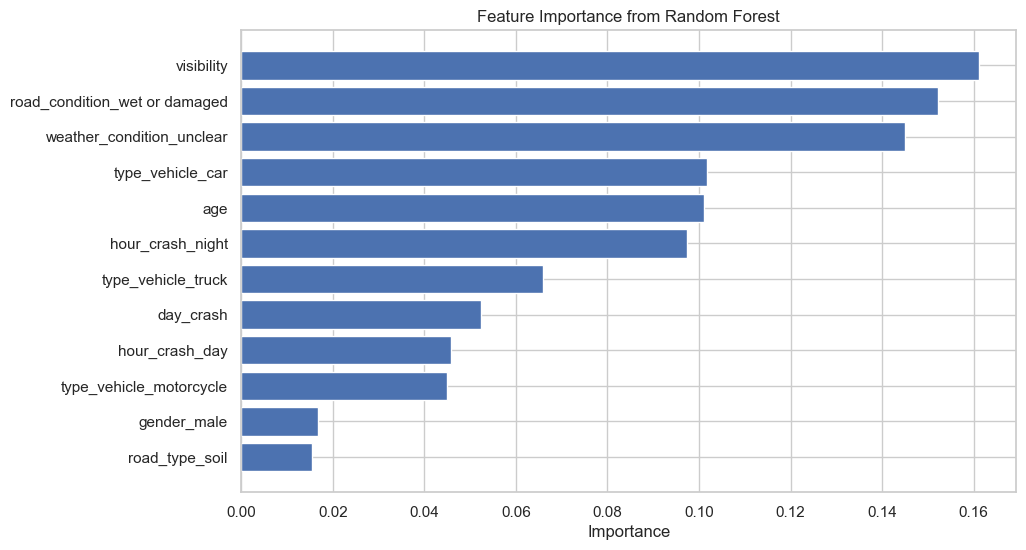

In [115]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Train Random Forest for feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


##  Step 30: Innovation - Feature Importance with Random Forest (Function-Based)

As part of the innovation in this project, we introduced a reusable function called `plot_feature_importance()` that leverages a **Random Forest Classifier** to determine and visualize which features are most important in predicting accident outcomes.

By passing in the training features and labels, the function automatically trains the model, calculates feature importances, and plots a horizontal bar chart. This approach not only enhances **interpretability**, but also adds **modularity** and **reusability** to the codebase.

The chart makes it easier to identify which variables (like weather condition, vehicle type, or road condition) play the most significant roles in accident severity, allowing stakeholders to focus on key risk factors.


In [116]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(X_train, y_train):
    """
    Train a Random Forest model and plot feature importances.
    """
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    
    importances = rf_model.feature_importances_
    features = X_train.columns
    
    feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_importance = feat_importance.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    plt.barh(feat_importance['Feature'], feat_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance from Random Forest')
    plt.gca().invert_yaxis()
    plt.show()


##  Step 31: Integrated Innovation – Feature Importance in Main Execution

To make the project more robust and automated, the `plot_feature_importance()` function was integrated directly into the `main()` function. This ensures that **feature importance visualization** is automatically executed as part of the main analysis pipeline.

This step enhances the overall **workflow automation** and ensures that when the model is trained and evaluated, a visual interpretation of feature relevance is also presented—improving the model's **transparency** and **decision-making support**.

By embedding the innovation inside the `main()` function, it becomes a seamless part of the full machine learning process.


In [117]:
def main():
    # ... your existing code ...

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate model
    evaluate_model(model, X_test, y_test)
    
    # **Innovation: Show feature importance using Random Forest**
    plot_feature_importance(X_train, y_train)


#  Road Accident Prediction Analysis with Python

##  Overview
This Python script performs data preprocessing, model training, evaluation, and an innovation step for understanding feature importance in predicting road accident outcomes.

##  Step-by-Step Breakdown

###  Step 1: Load the Dataset
- The `load_data()` function reads the CSV file `synthetic_road_accidents.csv` into a Pandas DataFrame.

###  Step 2: Clean the Dataset
- The `clean_data()` function removes rows with missing values using `dropna()` to ensure model reliability.

###  Step 3: Encode Categorical Features
- The `encode_data()` function applies **one-hot encoding** to all categorical columns using `pd.get_dummies()`.

###  Step 4: Define Target and Features
- The target column is `outcome`, and all other columns are treated as features.
- This split is done right after cleaning and before encoding.

###  Step 5: Train-Test Split
- The dataset is split into **80% training** and **20% testing** using `train_test_split()` with a fixed `random_state=42`.

###  Step 6: Train the Logistic Regression Model
- The `train_model()` function fits a logistic regression model with a maximum of 1000 iterations for better convergence.

###  Step 7: Evaluate the Model
- The `evaluate_model()` function prints multiple metrics:
  - Accuracy
  - Precision
  - Recall
  - F1 Score
  - Full Classification Report

###  Step 8:  Innovation – Feature Importance with Random Forest
- The `plot_feature_importance()` function uses a Random Forest Classifier to:
  - Train on the data.
  - Calculate feature importances.
  - Visualize them using a **horizontal bar plot** for better interpretability.
- This step highlights **which features most influence the accident outcome prediction**, adding **transparency** and **insight** to the machine learning process.

###  Step 9: Main Function
- The `main()` function ties everything together.
- Running this script will:
  1. Load, clean, and encode the data.
  2. Train and evaluate a logistic regression model.
  3. Automatically display a feature importance plot.

##  Summary
This project demonstrates how to go from raw CSV data to model training and performance evaluation, and even enhance the model interpretability using a Random Forest for feature importance—making it both technically solid and insight-rich.



Accuracy: 0.9983333333333333
Precision: 0.9833333333333333
Recall: 1.0
F1 Score: 0.9915966386554622

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       541
           1       0.98      1.00      0.99        59

    accuracy                           1.00       600
   macro avg       0.99      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



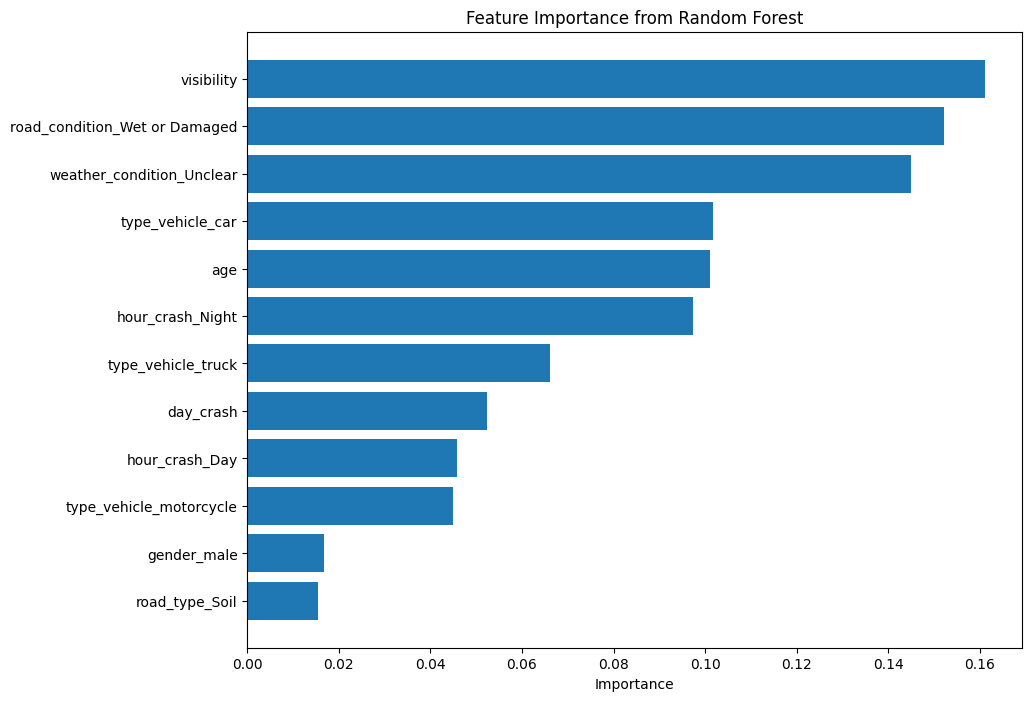

In [1]:
# analysis.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def load_data(file_path):
    """Load dataset from CSV file."""
    df = pd.read_csv(file_path)
    return df

def clean_data(df):
    """Clean the dataset by handling missing values."""
    df_cleaned = df.dropna()
    return df_cleaned

def encode_data(df):
    """Encode categorical columns using one-hot encoding."""
    categorical_cols = df.select_dtypes(include=['object']).columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df_encoded

def train_model(X_train, y_train):
    """Train a logistic regression model on the training data."""
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate the trained model and print classification metrics."""
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

def plot_feature_importance(X_train, y_train):
    """Train Random Forest and plot feature importance."""
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    
    importances = rf_model.feature_importances_
    features = X_train.columns
    
    feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_importance = feat_importance.sort_values(by='Importance', ascending=True)
    
    plt.figure(figsize=(10,8))
    plt.barh(feat_importance['Feature'], feat_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance from Random Forest')
    plt.show()

def main():
    # Load data
    df = load_data('synthetic_road_accidents.csv')
    
    # Clean data
    df = clean_data(df)
    
    # Separate target and features
    y = df['outcome']
    X = df.drop('outcome', axis=1)
    
    # Encode features
    X_encoded = encode_data(X)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    
    # Train logistic regression model
    model = train_model(X_train, y_train)
    
    # Evaluate logistic regression model
    evaluate_model(model, X_test, y_test)
    
    # Innovation: Feature importance analysis with Random Forest
    plot_feature_importance(X_train, y_train)

if __name__ == "__main__":
    main()


In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("synthetic_road_accidents.csv")

# Fill missing values for numeric columns with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Fill missing values for categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Save the cleaned dataset (optional)
df.to_csv("synthetic_road_accidents_filled.csv", index=False)


In [2]:
# Standardize text columns to lowercase and remove extra spaces
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.lower().str.strip()


In [3]:
print(df.shape)


(3000, 10)
